## Quantification and comparison of sine and sky gadient stimuli

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from scipy.signal import convolve2d, correlate
from scipy.stats import zscore
from pathlib import Path
from os.path import sep
import pandas as pd
import scipy as sp
import matplotlib.colors as colors
from PIL import Image

%matplotlib inline

np.random.seed(seed=3)
%config Completer.use_jedi = False  #magic to fix autocomplete issue

#### Creating a lookup table for transforming an image from a nonlinear to a linear colormap

In [2]:
pix = np.arange(0,256,1)

Save the Greys colourmap and reimport the image to map specified pixel values to the colourmap pixel values.

In [3]:
fig = plt.figure(frameon=False)
fig.set_size_inches(0.01,2.56)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(pix.reshape(256,1),cmap="Greys",origin='lower');
fig.savefig("calibration"+sep+"Greymap.png",dpi=100)

Grpix = np.asarray(Image.open("calibration"+sep+"Greymap.png"))

In [4]:
cmaplookupDf = pd.DataFrame(Grpix[:,0,0],columns=['Iin'])
cmaplookupDf['Iout'] = pix
cmaplookupDf.to_csv("screenMeasurements/Greys_to_gray.csv")

gtoG is a transformation from the linear colourmap to a non-linear colourmap.

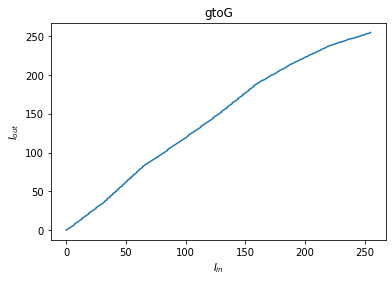

In [5]:
from scipy.optimize import minimize

y = np.array(cmaplookupDf['Iout'].values)
x = np.arange(0,256,1)
y = np.zeros(x.shape)

b = sp.interpolate.interp1d(cmaplookupDf['Iout'], cmaplookupDf['Iin'],bounds_error=False)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(np.round(y).astype('int'),x)
plt.title("gtoG")
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");

cmaplookupDfInv = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

Gtog = gtoG$^{-1}$

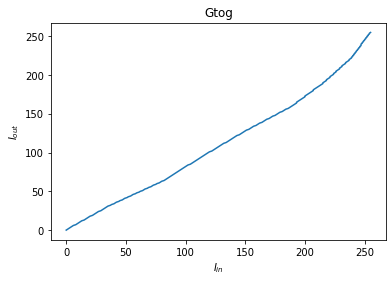

In [6]:
plt.plot(cmaplookupDf['Iin'], cmaplookupDf['Iout'])
plt.xlabel("$I_{in}$")
plt.ylabel("$I_{out}$")
plt.title("Gtog");

### Comparison of modulation of input images and images as shown on projector
(based on measured input->brightness curve and colour correction)

In [7]:
maxBit = 255 #assuming 8bit image depth
npts = 1000

def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def simulateI(img):
    x = img.flatten()
    y = np.array(transformDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def gtoG(img):
    x = (img).astype('int').flatten()
    y = np.array(cmaplookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def Gtog(img):
    x = np.round(img).astype('int').flatten()
    y = np.array(cmaplookupDfInv.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

**Generate gradients**

In [8]:
panGrad = (np.sin(np.linspace(0,np.pi*2,npts)) + 1) *maxBit/2
panGradLow = (np.sin(np.linspace(0,np.pi*2,npts)) + 2)*maxBit/4
panGradVeryLow = (np.sin(np.linspace(0,np.pi*2,npts)) + 4)*maxBit/8

panGradLowBright = (np.sin(np.linspace(0,np.pi*2,npts)) + 2)*maxBit/4 + maxBit/4
panGradVeryLowBright = (np.sin(np.linspace(0,np.pi*2,npts)) + 4)*maxBit/8 + 3*maxBit/8

panWidth = np.linspace(0,1,npts)

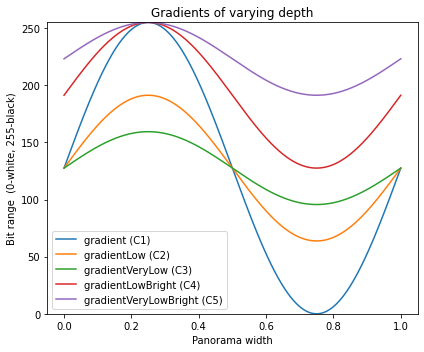

In [9]:
fig, axs = plt.subplots(1,1,figsize=(6,5))

axs.plot(panWidth,panGrad, label='gradient (C1)')
axs.plot(panWidth,panGradLow, label='gradientLow (C2)')
axs.plot(panWidth,panGradVeryLow, label='gradientVeryLow (C3)')
axs.plot(panWidth,panGradLowBright, label='gradientLowBright (C4)')
axs.plot(panWidth,panGradVeryLowBright, label='gradientVeryLowBright (C5)')
axs.set_title('Gradients of varying depth')
axs.set_ylim((0,maxBit))
axs.set_xlabel('Panorama width')
axs.set_ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
axs.legend()
fig.tight_layout()

**Load screen brightess measurements and generate transforms of gradients**

In [10]:
Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "Shivam" #"Shivam"#

if rig == "Shivam":
    file2 = rig+"Rig_mean_brightness_level_6.csv"
else:
    file2 = rig+"Rig_mean_brightness.csv"
    
file = rig+"Rig_lookup_table_transformed_brightness.csv"

lookupDf = pd.read_csv(Dir+file,index_col=0)
mean_brightness = pd.read_csv(Dir+file2)

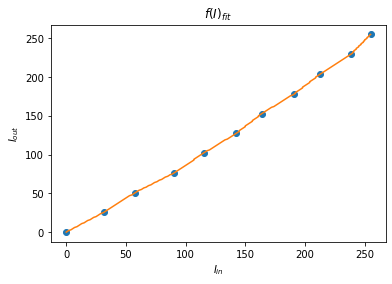

In [11]:
from scipy.optimize import minimize

y = np.array(mean_brightness['I'].values)
x = np.arange(0,256,1)
y = np.zeros(x.shape)

b = sp.interpolate.interp1d(mean_brightness['I'], mean_brightness['Stim'],bounds_error=False)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['I'].values,mean_brightness['Stim'].values,'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");

transformDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

No handles with labels found to put in legend.


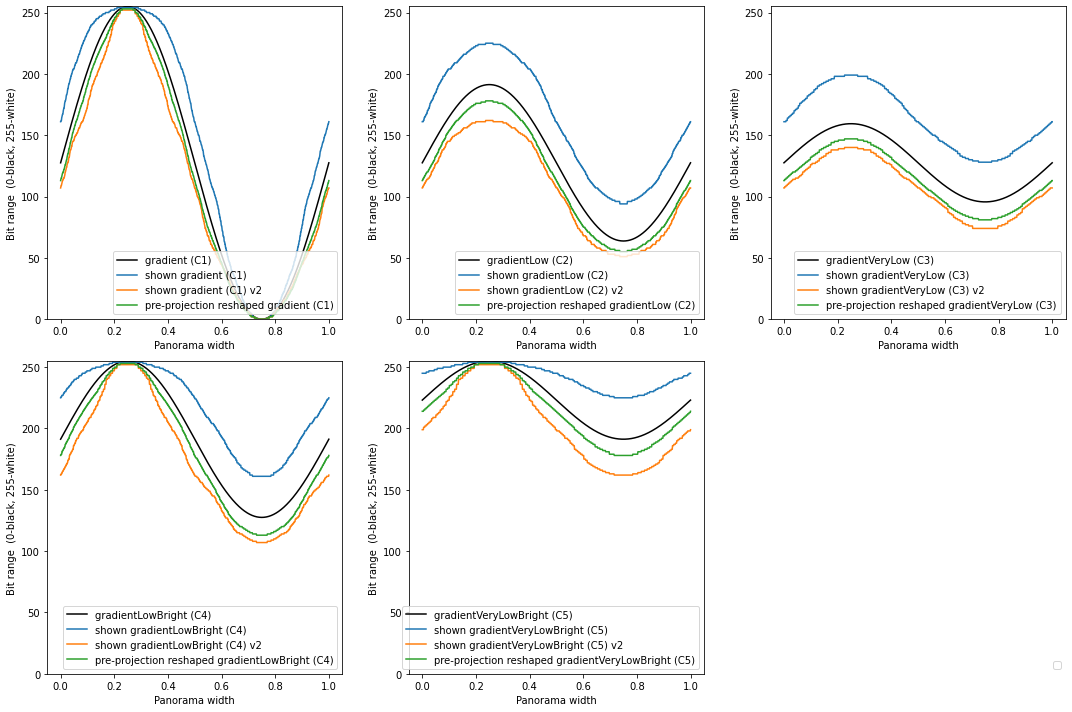

In [12]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

axs[0,0].plot(panWidth,panGrad,'k', label='gradient (C1)')
axs[0,1].plot(panWidth,panGradLow,'k', label='gradientLow (C2)')
axs[0,2].plot(panWidth,panGradVeryLow,'k', label='gradientVeryLow (C3)')
axs[1,0].plot(panWidth,panGradLowBright,'k', label='gradientLowBright (C4)')
axs[1,1].plot(panWidth,panGradVeryLowBright,'k', label='gradientVeryLowBright (C5)')

axs[0,0].plot(panWidth,simulateI(gtoG(panGrad)), label='shown gradient (C1)')
axs[0,1].plot(panWidth,simulateI(gtoG(panGradLow)), label='shown gradientLow (C2)')
axs[0,2].plot(panWidth,simulateI(gtoG(panGradVeryLow)), label='shown gradientVeryLow (C3)')
axs[1,0].plot(panWidth,simulateI(gtoG(panGradLowBright)), label='shown gradientLowBright (C4)')
axs[1,1].plot(panWidth,simulateI(gtoG(panGradVeryLowBright)), label='shown gradientVeryLowBright (C5)')

if rig=="Shivam":
    axs[0,0].plot(panWidth,simulateI(Gtog(rescale(panGrad))), label='shown gradient (C1) v2')
    axs[0,1].plot(panWidth,simulateI(Gtog(rescale(panGradLow))), label='shown gradientLow (C2) v2')
    axs[0,2].plot(panWidth,simulateI(Gtog(rescale(panGradVeryLow))), label='shown gradientVeryLow (C3) v2')
    axs[1,0].plot(panWidth,simulateI(Gtog(rescale(panGradLowBright))), label='shown gradientLowBright (C4) v2')
    axs[1,1].plot(panWidth,simulateI(Gtog(rescale(panGradVeryLowBright))), label='shown gradientVeryLowBright (C5) v2')

axs[0,0].plot(panWidth,rescale(panGrad), label='pre-projection reshaped gradient (C1)')
axs[0,1].plot(panWidth,rescale(panGradLow), label='pre-projection reshaped gradientLow (C2)')
axs[0,2].plot(panWidth,rescale(panGradVeryLow), label='pre-projection reshaped gradientVeryLow (C3)')
axs[1,0].plot(panWidth,rescale(panGradLowBright), label='pre-projection reshaped gradientLowBright (C4)')
axs[1,1].plot(panWidth,rescale(panGradVeryLowBright), label='pre-projection reshaped gradientVeryLowBright (C5)')

axs[1,2].axis('off')

for i in range(3):
    for ax in axs[:,i]:
        ax.set_ylim((0,maxBit))
        ax.set_xlabel('Panorama width')
        ax.set_ylabel('Bit range  (0-black, {}-white)'.format(maxBit));
        ax.legend(loc = "lower right")
fig.tight_layout()

## Plot the gradients as they appear on the projector

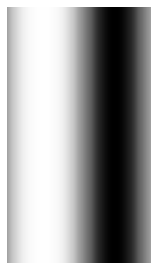

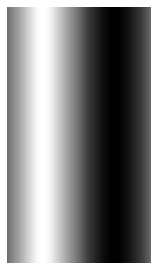

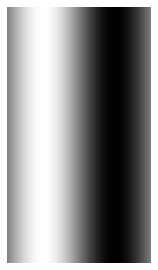

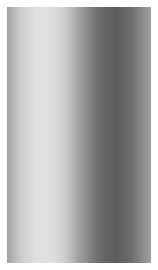

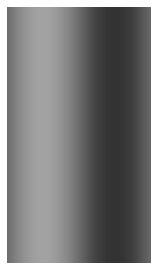

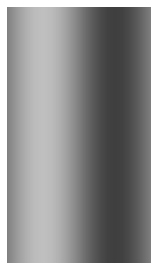

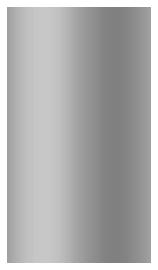

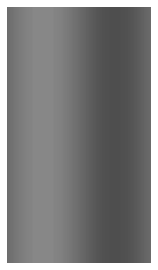

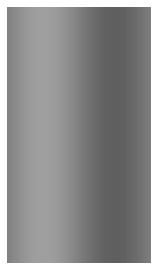

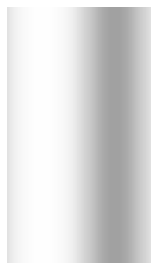

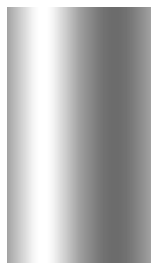

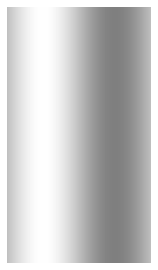

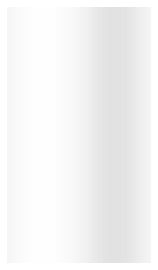

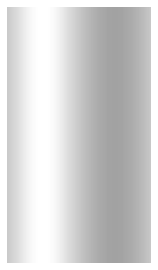

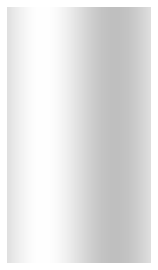

In [15]:
saveDir = "plots/shown"
Path(saveDir).mkdir(parents=True, exist_ok=True)

grads = ["gradient", "gradientLow", "gradientVeryLow", "gradientLowBright", "gradientVeryLowBright"]
for i, pan in enumerate([panGrad, panGradLow, panGradVeryLow, panGradLowBright, panGradVeryLowBright]):
    pan_shown = simulateI(gtoG(pan))
    pan_shown_v2 = simulateI(rescale(Gtog(pan)))
    pan_shown_reshaped = simulateI(rescale(pan))
    
    if rig=="Shivam": htfrac = 1280/720
    else: htfrac = 720/(480*4)
    ht = int(len(pan_shown)*htfrac)
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2,2*htfrac)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(np.tile(pan_shown,ht).reshape(ht,len(pan_shown)), cmap='gray', 
               vmin=0, vmax=maxBit);
    plt.savefig(saveDir+"/{}_shown_{}Rig.png".format(grads[i],rig),dpi = 300);
    
    if rig=="Shivam":
        fig = plt.figure(frameon=False)
        fig.set_size_inches(2,2*htfrac)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.imshow(np.tile(pan_shown_v2,ht).reshape(ht,len(pan_shown_v2)), cmap='gray', 
                   vmin=0, vmax=maxBit);
        #plt.savefig(saveDir+"/{}_shown_v2_{}Rig.png".format(grads[i], rig),dpi = 300);
        #plt.savefig
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2,2*htfrac)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(np.tile(pan_shown_reshaped,ht).reshape(ht,len(pan_shown_reshaped)), cmap='gray', 
               vmin=0, vmax=maxBit);
    plt.savefig(saveDir+"/{}_shown_reshaped_{}Rig.png".format(grads[i], rig),dpi = 300);

### Evaluation of gradients present in sky images

In [18]:
from PIL import Image
root = './skyGradients/originals/'
savename = '19h'
folder = savename+'/'# 'unity-skybox-16h-el48_52-az250_65/'#'unity-skybox-13h-el68_25-az169_56/'#

path = root + folder
maxBit = 255

In [19]:
grad_F = Image.open(path + 'SkyBox_Front.png')
grad_L = Image.open(path + 'SkyBox_Left.png')
grad_R = Image.open(path + 'SkyBox_Right.png')
grad_B = Image.open(path + 'SkyBox_Back.png')
grad_U = Image.open(path + 'SkyBox_Up.png')
grad_D = Image.open(path + 'SkyBox_Down.png')

arrB = np.zeros((grad_F.size[0],grad_F.size[1],6))
arrG = np.zeros((grad_F.size[0],grad_F.size[1],6))
arrR = np.zeros((grad_F.size[0],grad_F.size[1],6))

arrAll = np.zeros((grad_F.size[0],grad_F.size[1],4,6))

arrAll[:,:,:,2] = np.array(grad_F)
arrAll[:,:,:,3] = np.array(grad_L)
arrAll[:,:,:,0] = np.array(grad_B)
arrAll[:,:,:,1] = np.array(grad_R)
arrAll[:,:,:,4] = np.array(grad_U)
arrAll[:,:,:,5] = np.array(grad_D)

horizon = int(grad_F.size[1]/2)

In [20]:
# make long array by concatenating side faces, clip out bottom part (below horizon)

arrSides = np.zeros((horizon,grad_F.size[1]*4,4))
for i in range(4):
    arrSides[:,grad_F.size[1]*i:grad_F.size[1]*(i+1),:] = arrAll[:horizon,:,:,i]
    
cmaps = ['Reds','Greens','Blues']
lab = ['red','green','blue']

elevation = np.linspace(0,horizon-1,7).astype('int')

In [21]:
# sine gradient comparison
panGradSky = (np.sin(np.linspace(0,np.pi*2,arrSides.shape[1])) + 1) *maxBit/2
panGradLowSky = (np.sin(np.linspace(0,np.pi*2,arrSides.shape[1])) + 2)*maxBit/4
panGradLowBrightSky = (np.sin(np.linspace(0,np.pi*2,arrSides.shape[1])) + 2)*maxBit/4 + maxBit/4

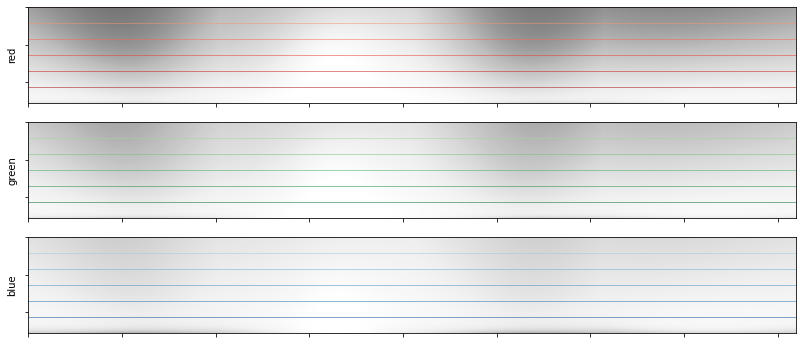

In [23]:
fig, axs = plt.subplots(3,1,figsize=(15,6))

for c in range(3):
    axs[c].imshow(arrSides[:,:,c], cmap='Greys_r', vmin=150, vmax=255)
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].axhline(e,color=myCMap.to_rgba(i+1), linewidth=0.5)
    axs[c].axes.xaxis.set_ticklabels([])
    axs[c].axes.yaxis.set_ticklabels([])
    axs[c].set_ylabel(lab[c])
#plt.savefig('./plots/skygradients_RGB_original_{}.pdf'.format(savename))

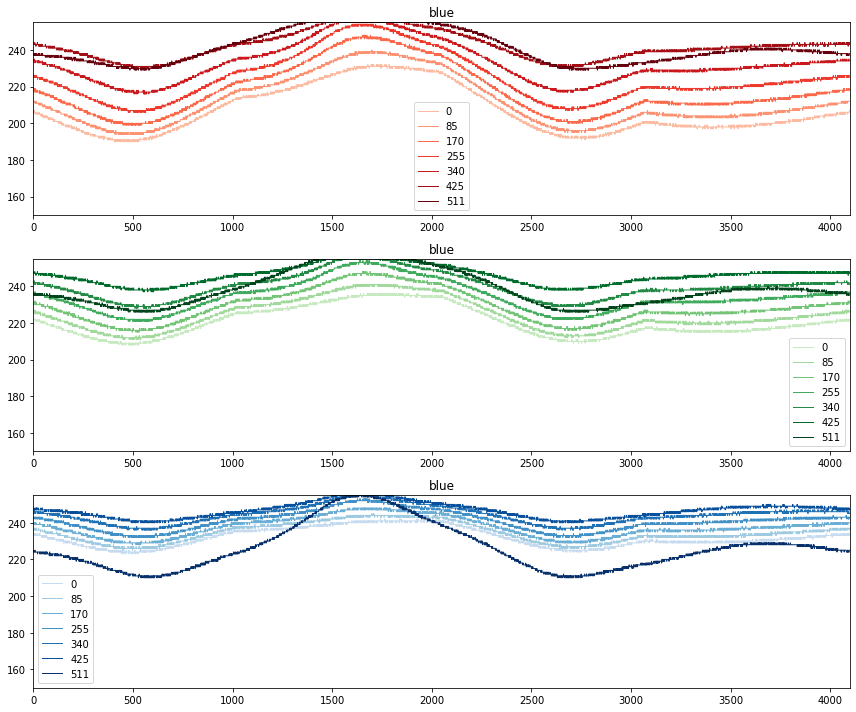

In [25]:
fig, axs = plt.subplots(3,1,figsize=(12,10))
for c in range(3):
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].plot(arrSides[e,:,c],'-',color=myCMap.to_rgba(i+1), label=e, linewidth=1)

for i, ax in enumerate(axs):
    ax.set_ylim(150,255)
    ax.set_xlim(0,grad_F.size[1]*4)
    ax.legend()
    ax.set_title(lab[c])
fig.tight_layout()
#plt.savefig('./plots/skygradients_RGB_elevationProfile_{}.pdf'.format(savename))

### Rescale naturalistic gradients to make them span a range from 150 - 255

In [26]:
increase = 200

In [27]:
arrSidesScaled = (arrSides[:,:,:] - increase)
arrSidesScaled = (arrSidesScaled/np.max(arrSidesScaled[:,:,:]))
arrSidesScaled = maxBit *(arrSidesScaled)

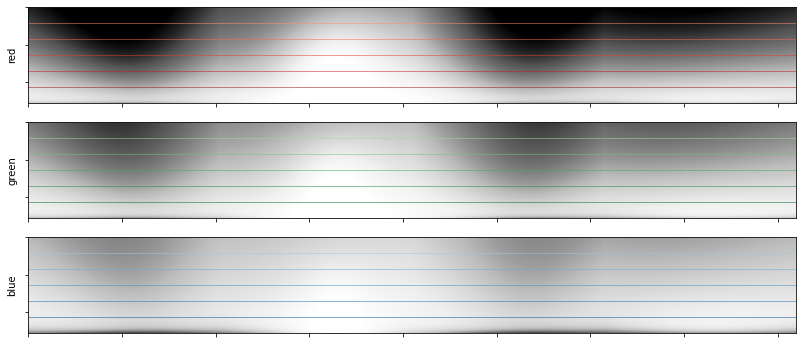

In [29]:
fig, axs = plt.subplots(3,1,figsize=(15,6))

for c in range(3):
    axs[c].imshow(arrSidesScaled[:,:,c], cmap='Greys_r', vmin=0, vmax=255)
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].axhline(e,color=myCMap.to_rgba(i+1), linewidth=0.5)
    axs[c].axes.xaxis.set_ticklabels([])
    axs[c].axes.yaxis.set_ticklabels([])
    axs[c].set_ylabel(lab[c])
#plt.savefig('./plots/skygradients_RGB_rescaled_{}.pdf'.format(savename))

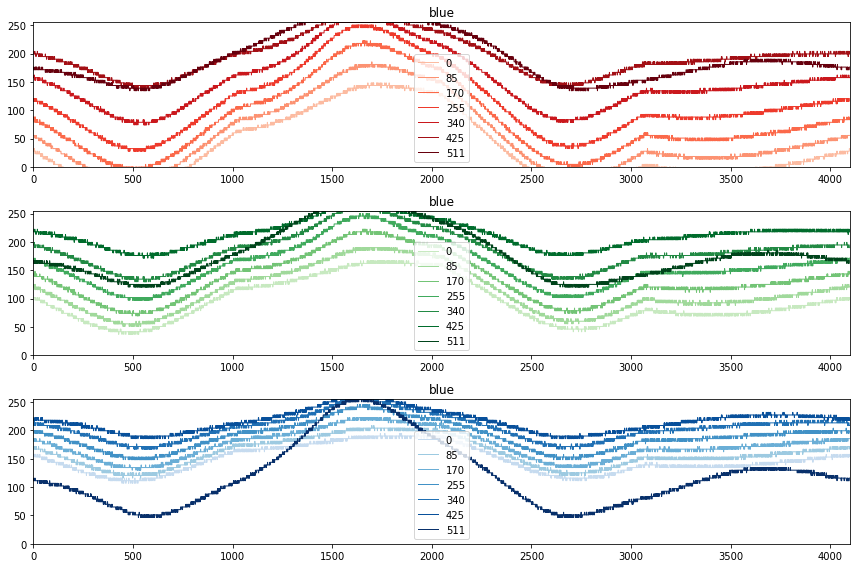

In [31]:
fig, axs = plt.subplots(3,1,figsize=(12,8))
for c in range(3):
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].plot(arrSidesScaled[e,:,c],'-',color=myCMap.to_rgba(i+1), label=e, linewidth=1)

for i, ax in enumerate(axs):
    ax.set_ylim(0,255)
    ax.set_xlim(0,grad_F.size[1]*4)
    ax.legend()
    ax.set_title(lab[c])
fig.tight_layout()
#plt.savefig('./plots/skygradients_RGB_elevationProfileRescaled_{}.pdf'.format(savename))

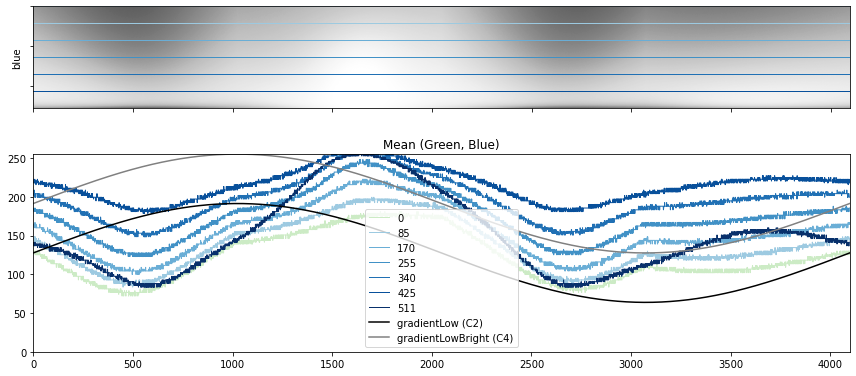

In [33]:
arrSidesScaledBG = (arrSidesScaled[:,:,1]  + arrSidesScaled[:,:,2])/2

fig, axs = plt.subplots(2,1,figsize=(12,6))

cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='GnBu')
for i, e in enumerate(elevation):
    axs[1].plot(arrSidesScaledBG[e,:],'-',color=myCMap.to_rgba(i+1), label=e, linewidth=1)
    axs[0].imshow(arrSidesScaledBG, cmap='Greys_r', vmin=0, vmax=255)
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[0].axhline(e,color=myCMap.to_rgba(i+1), linewidth=0.5)
axs[0].axes.xaxis.set_ticklabels([])
axs[0].axes.yaxis.set_ticklabels([])
axs[0].set_ylabel(lab[c])

axs[1].plot(np.linspace(0,arrSides.shape[1],arrSides.shape[1]) ,panGradLowSky,color='k', label='gradientLow (C2)')
axs[1].plot(np.linspace(0,arrSides.shape[1],arrSides.shape[1]),panGradLowBrightSky,color='grey', label='gradientLowBright (C4)')
axs[1].set_ylim(0,255)
axs[1].set_xlim(0,grad_F.size[1]*4)
axs[1].legend()
axs[1].set_title('Mean (Green, Blue)')
fig.tight_layout()
#plt.savefig('./plots/skygradients_GBmeanRescaled_imageAndElevationProfile_{}.pdf'.format(savename))

In [35]:
pt_per_cm = 150
dpiVal = 1000

maxBitSave = 2000

savename = '13h'
path = './skyGradients/'+savename+'/'

for side, name in enumerate(['Back','Right','Front','Left','Up','Down']):

    grad = np.asarray(Image.open(path + 'Skybox_mean_{}_{}.png'.format(name,savename)))

    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rescale(grad), cmap='binary')
    #fig.savefig(path+"Skybox_reshaped_{}_{}_{}.png".format(name,savename,rig),dpi = dpiVal)

FileNotFoundError: [Errno 2] No such file or directory: './skyGradients/13h/Skybox_mean_Back_13h.png'